In [58]:
import tensorflow as tf
import os
import splitfolders as sf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, roc_auc_score
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, concatenate, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dir = r'A:\AI DB\LSPD\images_pret\train'
validation_dir = r'A:\AI DB\LSPD\images_pret\val'
test_dir = r'A:\AI DB\LSPD\images_pret\test'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 256

In [4]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5] 
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 450000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [114]:
class MobileNetV3Model(Model):
    def __init__(self):
        super(MobileNetV3Model, self).__init__()
        self.mobile_netv3 = tf.keras.applications.MobileNetV3Small(
            weights='imagenet',
            input_shape=(img_height, img_width, 3),
            include_top=False,
            pooling='avg'
        )
        self.last_layers = self.mobile_netv3.layers[-10:]  # Expose last 10 layers
    
    def call(self, inputs):
        return self.mobile_netv3(inputs)

class DenseNet169Model(Model):
    def __init__(self):
        super(DenseNet169Model, self).__init__()
        self.densenet169 = tf.keras.applications.DenseNet169(
            weights='imagenet',
            input_shape=(img_height, img_width, 3),
            include_top=False,
            pooling='avg'
        )
        self.last_layers = self.densenet169.layers[-10:]  # Expose last 10 layers
    
    def call(self, inputs):
        return self.densenet169(inputs)

In [74]:
# Instantiate the MobileNetV3 and DenseNet169 models as subclassed layers
mobile_netv3_model = MobileNetV3Model()
densenet169_model = DenseNet169Model()

In [7]:
# Define input layer for the two pretrained models
input_layer =  tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_layer')

# Pass input through the first pretrained model (MobileNetV3)
output_mobile_netv3 = mobile_netv3_model(input_layer)

# Pass the same input through the second pretrained model (DenseNet169)
output_densenet169 = densenet169_model(input_layer)

# Concatenate the outputs of the two pretrained models
combined_features =  tf.keras.layers.Concatenate()([output_mobile_netv3, output_densenet169])

# Add additional layers
x =  tf.keras.layers.Flatten()(combined_features)
x =  tf.keras.layers.Dense(512, activation='relu')(x)
x =  tf.keras.layers.Dropout(0.3)(x)
output_layer =  tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the combined model
model_combined =  tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Freeze the convolutional layers
for layer in mobile_netv3_model.layers:
    layer.trainable = False
for layer in densenet169_model.layers:
    layer.trainable = False

# Compile the model with hyperparameter tuning
model_combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ])

In [8]:
model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobile_net_v3_model (MobileNet  (None, 576)         939120      ['input_layer[0][0]']            
 V3Model)                                                                                         
                                                                                                  
 dense_net169_model (DenseNet16  (None, 1664)        12642880    ['input_layer[0][0]']            
 9Model)                                                                                      

In [11]:
checkpoint_filepath = r'A:\AI DB\LSPD\models\MultiModal.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Convert class weights to a dictionary format
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

In [10]:
total_epochs=10

In [12]:
# Train the combined model with class weights
history = model_combined.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weights_dict  # Pass the class weights dictionary here
)

Epoch 1/10
1757/1757 [==============================] - 10044s 6s/step - loss: 0.1607 - accuracy: 0.9384 - val_loss: 0.1161 - val_accuracy: 0.9568
Epoch 2/10
1757/1757 [==============================] - 9932s 6s/step - loss: 0.1403 - accuracy: 0.9471 - val_loss: 0.1068 - val_accuracy: 0.9610
Epoch 3/10
1757/1757 [==============================] - 9934s 6s/step - loss: 0.1332 - accuracy: 0.9501 - val_loss: 0.1025 - val_accuracy: 0.9623
Epoch 4/10
1757/1757 [==============================] - 9894s 6s/step - loss: 0.1295 - accuracy: 0.9515 - val_loss: 0.1079 - val_accuracy: 0.9604
Epoch 5/10
1757/1757 [==============================] - 10090s 6s/step - loss: 0.1274 - accuracy: 0.9524 - val_loss: 0.1096 - val_accuracy: 0.9599
Epoch 6/10
1757/1757 [==============================] - 9872s 6s/step - loss: 0.1257 - accuracy: 0.9530 - val_loss: 0.1010 - val_accuracy: 0.9636
Epoch 7/10
1757/1757 [==============================] - 9950s 6s/step - loss: 0.1233 - accuracy: 0.9538 - val_loss: 0.1019

In [13]:
model_combined.save(checkpoint_filepath,save_format='tf',overwrite=True)

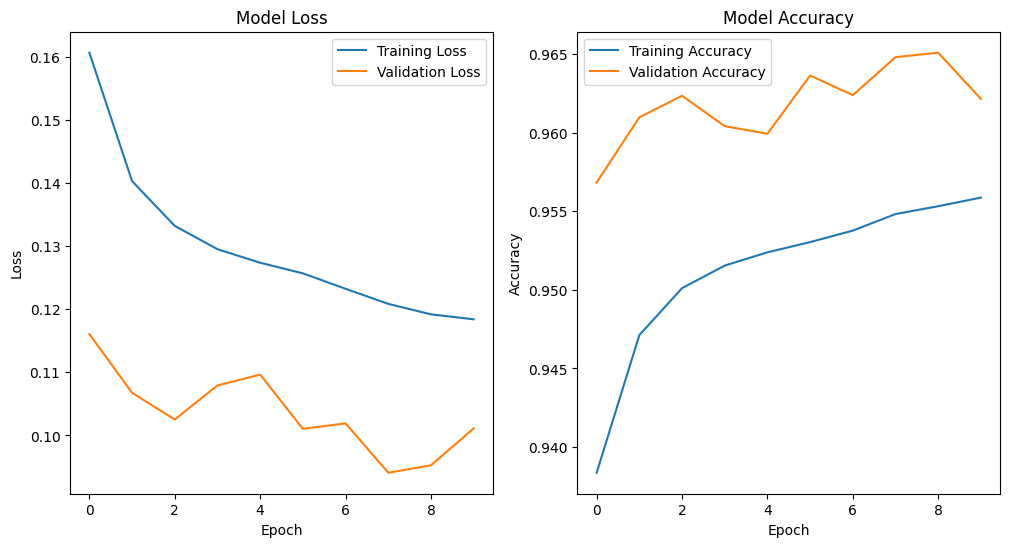

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
# Predict on the test set
ypred = model_combined.predict(test_generator)

98/98 [==============================] - 360s 4s/step


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     10000
           1       0.98      0.96      0.97     15000

    accuracy                           0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000



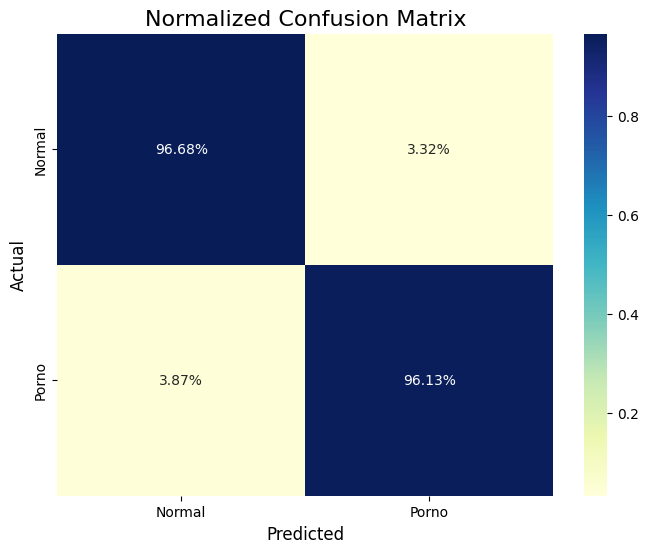

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_classes = (ypred > 0.5).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", cr)

# Plot the normalized confusion matrix with porno and normal labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'])
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.show()


In [85]:
# Pass input through the first pretrained model (MobileNetV3)
output_mobile_netv3 = mobile_netv3_model(input_layer)

# Pass the same input through the second pretrained model (DenseNet169)
output_densenet169 = densenet169_model(input_layer)

In [99]:
# Set the last layers of MobileNetV3 and DenseNet169 to be trainable
for layer in mobile_netv3_model.layers:
    layer.trainable = False

for layer in densenet169_model.layers:
    layer.trainable = False
    
for layer in mobile_netv3_model.layers[-10:]:
    print(layer.name)
    layer.trainable = True

for layer in densenet169_model.layers[-10:]:
    print(layer.name)
    layer.trainable = True

# Get the dropout layer by index
dropout_layer = model_combined.layers[4]  # Index 4 corresponds to the dropout layer

# Update the dropout rate
new_dropout_rate = 0.5  # For example, change the dropout rate to 0.5
dropout_layer.rate = new_dropout_rate

# Compile the model with possibly a lower learning rate for fine-tuning
model_combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=[
                           tf.keras.metrics.BinaryAccuracy(name='accuracy')
                       ])

expanded_conv_10/project
expanded_conv_10/project/BatchNorm
expanded_conv_10/Add
Conv_1
Conv_1/BatchNorm
tf.__operators__.add_53
re_lu_63
tf.math.multiply_53
multiply_35
avg_pool
conv5_block32_0_bn
conv5_block32_0_relu
conv5_block32_1_conv
conv5_block32_1_bn
conv5_block32_1_relu
conv5_block32_2_conv
conv5_block32_concat
bn
relu
avg_pool


In [100]:
checkpoint_filepath = r'A:\AI DB\LSPD\models\MultiModalUnfreeze.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

In [101]:
model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobile_net_v3_model (MobileNet  (None, 576)         939120      ['input_layer[0][0]']            
 V3Model)                                                                                         
                                                                                                  
 dense_net169_model (DenseNet16  (None, 1664)        12642880    ['input_layer[0][0]']            
 9Model)                                                                                      

In [39]:
# Continue training for another 2 epochs
history = model_combined.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    initial_epoch=total_epochs-1,
    epochs= total_epochs+2,  # Add 2 epochs to the total number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weights_dict
)

Epoch 10/12
 128/1757 [=>............................] - ETA: 2:33:28 - loss: 0.1143 - accuracy: 0.9581

KeyboardInterrupt: 

In [129]:
input_layer2 = tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_layer')

# Instantiate the MobileNetV3 model and make only the last 10 layers trainable
mobile_netv3 = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)

for layer in mobile_netv3.layers[:-20]:
    layer.trainable = False

# Pass input through the MobileNetV3 model
output_mobile_netv3 = mobile_netv3(input_layer2)

# Instantiate the DenseNet169 model and make only the last 10 layers trainable
densenet169 = tf.keras.applications.DenseNet169(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)

for layer in densenet169.layers[:-20]:
    layer.trainable = False

# Pass input through the DenseNet169 model
output_densenet169 = densenet169(input_layer2)

# Concatenate the outputs of the two pretrained models
combined_features = tf.keras.layers.Concatenate(name='concatenate')([output_mobile_netv3, output_densenet169])

# Add additional layers
x = tf.keras.layers.Flatten(name='flatten')(combined_features)
x = tf.keras.layers.Dense(512, activation='relu', name='dense')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
output_layer2 = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_1')(x)
combined_model2.summary()
# Create the combined model
combined_model2 = tf.keras.Model(inputs=input_layer2, outputs=output_layer2)

# Load weights from the file
#combined_model2.load_weights(r'A:\AI DB\LSPD\models\model_combined_weights.h5', by_name=True)
# Compile the model with hyperparameter tuning
combined_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 concatenate (Concatenate)      (None, 2624)         0           ['MobilenetV3large[0][0]',

ValueError: Shape mismatch in layer #5 (named dense) for weight dense/kernel:0. Weight expects shape (2624, 512). Received saved weight with shape (2240, 512)

In [126]:
combined_model2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 576)          939120      ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 concatenate (Concatenate)      (None, 2240)         0           ['MobilenetV3small[0][0]',

In [127]:
# Continue training for another 2 epochs
history = combined_model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    initial_epoch=total_epochs-1,
    epochs= total_epochs+2,  # Add 2 epochs to the total number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weights_dict
)

Epoch 10/12
 156/1757 [=>............................] - ETA: 2:34:13 - loss: 0.1831 - accuracy: 0.9350

KeyboardInterrupt: 

In [5]:
input_layer2 = tf.keras.layers.Input(shape=(img_height, img_width, 3), name='input_layer')
# Instantiate the MobileNetV3 model
mobilenetv3 = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)
output_mobilenetv3 = mobilenetv3(input_layer2)

# Instantiate the DenseNet169 model
densenet169 = tf.keras.applications.DenseNet169(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False,
    pooling='avg',
)
output_densenet169 = densenet169(input_layer2)

# Rename layers
for layer in mobilenetv3.layers:
    layer.trainable = False
for layer in densenet169.layers:
    layer.trainable = False

# Concatenate the outputs of the two pretrained models
combined_features = tf.keras.layers.Concatenate(name='concatenate')([
    output_mobilenetv3,
    output_densenet169
])

# Add additional layers
x = tf.keras.layers.Flatten(name='flatten')(combined_features)
x = tf.keras.layers.Dense(1024, activation='relu', name='dense')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
x = tf.keras.layers.Dense(512, activation='relu', name='dense2')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout2')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Create the combined model
combined_model = tf.keras.Model(inputs=input_layer2, outputs=output_layer)



In [6]:
# Define a custom learning rate scheduler based on performance and save best model
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, factor=0.5, min_lr=1e-6, filepath=r'A:\AI DB\LSPD\models\MultiModalUnfreeze.keras', save_best_only=True, layers_to_unfreeze=None):
        super(CustomLearningRateScheduler, self).__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_performance = float('inf')
        self.wait = 0
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.layers_to_unfreeze = layers_to_unfreeze

    def on_epoch_end(self, epoch, logs=None):
        current_performance = logs.get('val_loss')
        if current_performance < self.best_performance:
            self.best_performance = current_performance
            self.wait = 0
            if self.save_best_only:
                self.model.save(self.filepath, overwrite=True)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                lr = tf.keras.backend.get_value(self.model.optimizer.lr)
                if lr > self.min_lr:
                    new_lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                    print(f'\nLearning rate reduced to: {new_lr}\n')
                    self.wait = 0
                    # Unfreeze layers progressively based on epoch
                    if self.layers_to_unfreeze:
                        num_layers_to_unfreeze = int((epoch + 1) / 5)  # Adjust the divisor as needed
                        for layer in self.layers_to_unfreeze[:num_layers_to_unfreeze]:
                            layer.trainable = True
                        print(f'Unfroze {num_layers_to_unfreeze} layers.')



In [41]:
# Rename layers
for layer in mobilenetv3.layers[-20:]:
    layer.trainable = True
for layer in densenet169.layers[-20:]:
    layer.trainable = True

In [42]:
# Instantiate the custom learning rate scheduler and save best model
lr_scheduler = CustomLearningRateScheduler(patience=2, factor=0.5, min_lr=1e-6, filepath= r'A:\AI DB\LSPD\models\MultiModalUnfreeze.keras', save_best_only=True)

# Compile the model
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [43]:
combined_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 concatenate (Concatenate)      (None, 2624)         0           ['MobilenetV3large[0][0]',

In [9]:
combined_model=tf.keras.models.load_model(r'A:\\AI DB\\LSPD\\models\\MultiModalUnfreeze.keras')
combined_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 concatenate (Concatenate)      (None, 2624)         0           ['MobilenetV3large[0][0]',

In [13]:
epochs = 10
initial_epochs=4
# Train the top layers of the model
history2 = combined_model.fit(train_generator, validation_data=validation_generator, epochs=epochs,initial_epoch=initial_epochs, callbacks=[lr_scheduler], class_weight=class_weights_dict)



Epoch 5/10
1758/1758 [==============================] - 9891s 6s/step - loss: 0.1389 - accuracy: 0.9480 - val_loss: 0.1234 - val_accuracy: 0.9572
Epoch 6/10
1758/1758 [==============================] - 9969s 6s/step - loss: 0.1373 - accuracy: 0.9485 - val_loss: 0.1174 - val_accuracy: 0.9622
Epoch 7/10
1758/1758 [==============================] - 9846s 6s/step - loss: 0.1355 - accuracy: 0.9489 - val_loss: 0.1076 - val_accuracy: 0.9624
Epoch 8/10
1758/1758 [==============================] - 9822s 6s/step - loss: 0.1342 - accuracy: 0.9499 - val_loss: 0.1170 - val_accuracy: 0.9625
Epoch 9/10
1758/1758 [==============================] - 9853s 6s/step - loss: 0.1325 - accuracy: 0.9506 - val_loss: 0.1191 - val_accuracy: 0.9630
Epoch 10/10
1758/1758 [==============================] - 9857s 6s/step - loss: 0.1321 - accuracy: 0.9505 - val_loss: 0.1091 - val_accuracy: 0.9644


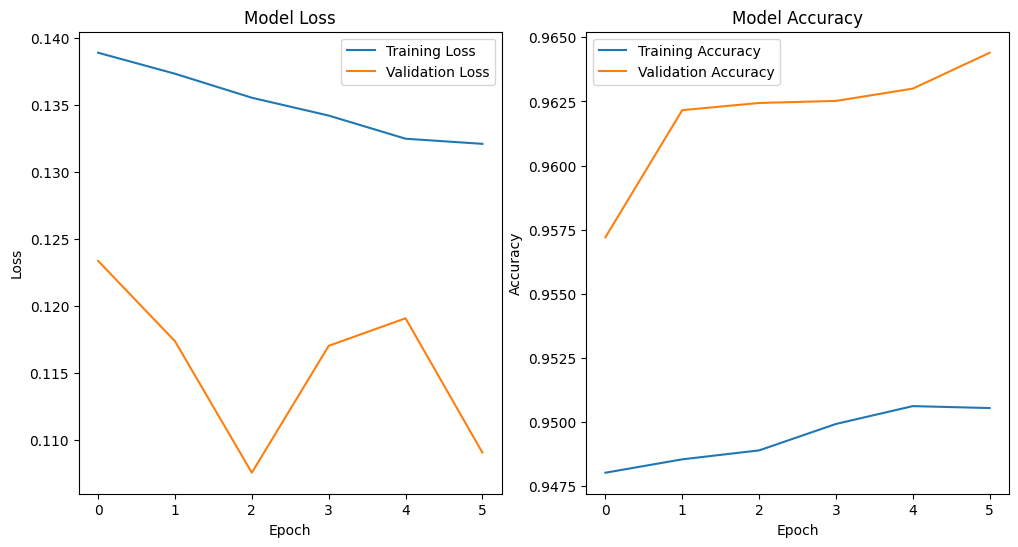

In [31]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
# Predict on the test set
ypred = combined_model.predict(test_generator)

98/98 [==============================] - 359s 4s/step


Classification Report:
               precision    recall  f1-score   support

           0     0.9584    0.9494    0.9539     10000
           1     0.9665    0.9725    0.9695     15000

    accuracy                         0.9633     25000
   macro avg     0.9624    0.9610    0.9617     25000
weighted avg     0.9632    0.9633    0.9633     25000



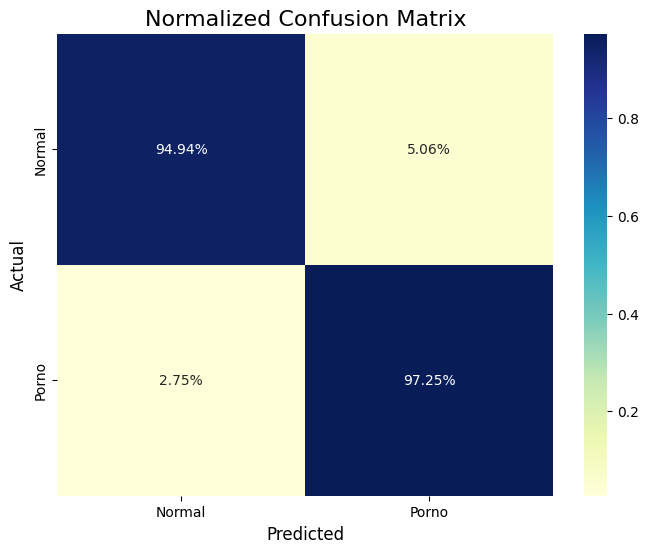

Accuracy Score: 0.9633
F1 Score: 0.9695


In [25]:
# Convert predicted probabilities to binary predictions
y_pred_classes = (ypred > 0.5).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes,digits=4)
print("Classification Report:\n", cr)

# Plot the normalized confusion matrix with porno and normal labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'])
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

In [33]:
combined_model.save(r'A:\AI DB\LSPD\models\MultiModalUnfreeze96.keras',save_format='tf',overwrite=True)

In [44]:
batch_size = 64

In [115]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5] 
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 450000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.
Found 30000 images belonging to 2 classes.


In [34]:
epochs = 14
initial_epochs=9
# Train the top layers of the model
history2 = combined_model.fit(train_generator, 
                              validation_data=validation_generator, 
                              epochs=epochs,
                              initial_epoch=initial_epochs,
                              callbacks=[lr_scheduler],
                              class_weight=class_weights_dict)


Epoch 10/14
14063/14063 [==============================] - 9985s 710ms/step - loss: 0.1552 - accuracy: 0.9436 - val_loss: 0.1148 - val_accuracy: 0.9594
Epoch 11/14
14063/14063 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9453
Learning rate reduced to: 0.0005000000237487257

Unfroze 2 layers.
14063/14063 [==============================] - 10007s 712ms/step - loss: 0.1518 - accuracy: 0.9453 - val_loss: 0.1270 - val_accuracy: 0.9608
Epoch 12/14
14063/14063 [==============================] - 10005s 711ms/step - loss: 0.1392 - accuracy: 0.9494 - val_loss: 0.1100 - val_accuracy: 0.9628
Epoch 13/14
14063/14063 [==============================] - 9989s 710ms/step - loss: 0.1358 - accuracy: 0.9505 - val_loss: 0.1068 - val_accuracy: 0.9631
Epoch 14/14
14063/14063 [==============================] - 10024s 713ms/step - loss: 0.1352 - accuracy: 0.9511 - val_loss: 0.1138 - val_accuracy: 0.9616


In [46]:
epochs = 20
initial_epochs=13
# Train the top layers of the model
history2 = combined_model.fit(train_generator, 
                              validation_data=validation_generator, 
                              epochs=epochs,
                              initial_epoch=initial_epochs,
                              callbacks=[lr_scheduler],
                              class_weight=class_weights_dict)

Epoch 14/20
7032/7032 [==============================] - 10053s 1s/step - loss: 0.1420 - accuracy: 0.9487 - val_loss: 0.1098 - val_accuracy: 0.9622
Epoch 15/20
7032/7032 [==============================] - 9960s 1s/step - loss: 0.1393 - accuracy: 0.9495 - val_loss: 0.1106 - val_accuracy: 0.9592
Epoch 16/20
7032/7032 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9494
Learning rate reduced to: 0.0005000000237487257

7032/7032 [==============================] - 9914s 1s/step - loss: 0.1398 - accuracy: 0.9494 - val_loss: 0.1139 - val_accuracy: 0.9632
Epoch 17/20
7032/7032 [==============================] - 9937s 1s/step - loss: 0.1315 - accuracy: 0.9519 - val_loss: 0.1074 - val_accuracy: 0.9619
Epoch 18/20
7032/7032 [==============================] - 9952s 1s/step - loss: 0.1302 - accuracy: 0.9519 - val_loss: 0.1092 - val_accuracy: 0.9630
Epoch 19/20
7032/7032 [==============================] - 9981s 1s/step - loss: 0.1290 - accuracy: 0.9527 - val_loss: 0.1012 - va

In [52]:
epochs = 25
initial_epochs=19
# Train the top layers of the model
history2 = combined_model.fit(train_generator, 
                              validation_data=validation_generator, 
                              epochs=epochs,
                              initial_epoch=initial_epochs,
                              callbacks=[lr_scheduler],
                              class_weight=class_weights_dict)

Epoch 20/25
7032/7032 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9532
Learning rate reduced to: 0.0002500000118743628

7032/7032 [==============================] - 9953s 1s/step - loss: 0.1282 - accuracy: 0.9532 - val_loss: 0.1027 - val_accuracy: 0.9644
Epoch 21/25
7032/7032 [==============================] - 9879s 1s/step - loss: 0.1246 - accuracy: 0.9540 - val_loss: 0.1090 - val_accuracy: 0.9637
Epoch 22/25
7032/7032 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9541
Learning rate reduced to: 0.0001250000059371814

7032/7032 [==============================] - 9906s 1s/step - loss: 0.1231 - accuracy: 0.9541 - val_loss: 0.1090 - val_accuracy: 0.9642
Epoch 23/25
7032/7032 [==============================] - 9881s 1s/step - loss: 0.1212 - accuracy: 0.9548 - val_loss: 0.1060 - val_accuracy: 0.9650
Epoch 24/25
7032/7032 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9548
Learning rate reduced to: 6.2500002968590

In [53]:
epochs = 30
initial_epochs=24
# Train the top layers of the model
history2 = combined_model.fit(train_generator, 
                              validation_data=validation_generator, 
                              epochs=epochs,
                              initial_epoch=initial_epochs,
                              callbacks=[lr_scheduler],
                              class_weight=class_weights_dict)

Epoch 25/30
7032/7032 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9558
Learning rate reduced to: 3.125000148429535e-05

7032/7032 [==============================] - 9955s 1s/step - loss: 0.1190 - accuracy: 0.9558 - val_loss: 0.1077 - val_accuracy: 0.9648
Epoch 26/30
7032/7032 [==============================] - 9906s 1s/step - loss: 0.1189 - accuracy: 0.9556 - val_loss: 0.1065 - val_accuracy: 0.9647
Epoch 27/30
7032/7032 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9557
Learning rate reduced to: 1.5625000742147677e-05

7032/7032 [==============================] - 9969s 1s/step - loss: 0.1187 - accuracy: 0.9557 - val_loss: 0.1069 - val_accuracy: 0.9650
Epoch 28/30
7032/7032 [==============================] - 9934s 1s/step - loss: 0.1193 - accuracy: 0.9554 - val_loss: 0.1059 - val_accuracy: 0.9653
Epoch 29/30
7032/7032 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9557
Learning rate reduced to: 7.812500371073

In [55]:
combined_model.save(r'A:\AI DB\LSPD\models\MultiModalUnfreezeLa5er.keras',save_format='tf',overwrite=True)

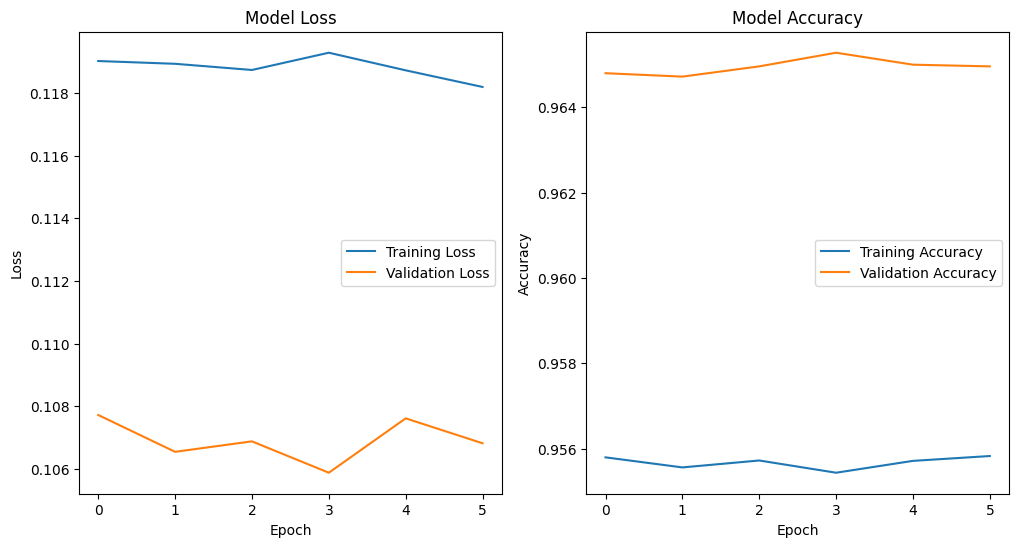

In [54]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
# Predict on the test set
ypred = combined_model.predict(test_generator)

469/469 [==============================] - 389s 828ms/step


Classification Report:
               precision    recall  f1-score   support

           0     0.9697    0.9593    0.9645     15000
           1     0.9598    0.9701    0.9649     15000

    accuracy                         0.9647     30000
   macro avg     0.9648    0.9647    0.9647     30000
weighted avg     0.9648    0.9647    0.9647     30000



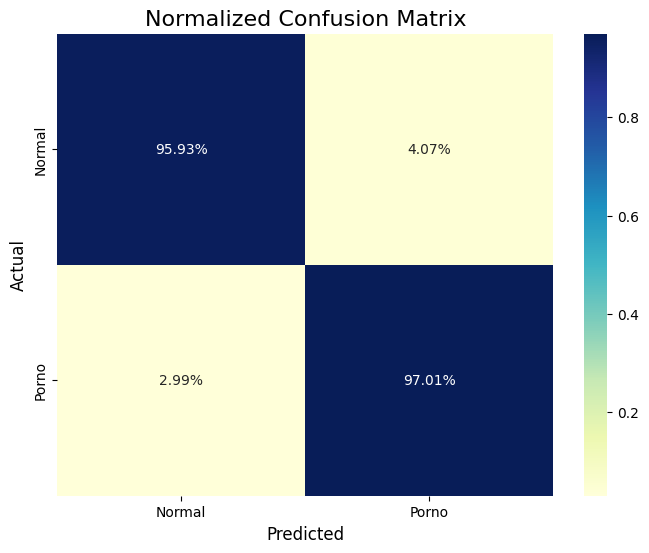

Accuracy Score: 0.9647
F1 Score: 0.9649


In [120]:
# Convert predicted probabilities to binary predictions
y_pred_classes = (ypred >  0.5700000000000001).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes,digits=4)
print("Classification Report:\n", cr)

# Plot the normalized confusion matrix with porno and normal labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'])
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

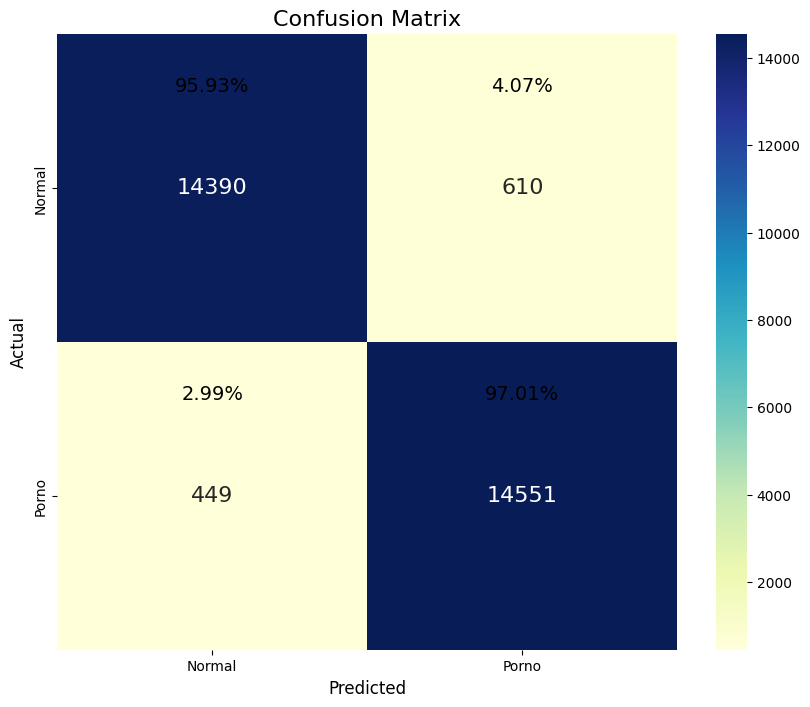

In [121]:
# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [119]:
from sklearn.metrics import accuracy_score, f1_score

ypred_prob=ypred
# Define a list of threshold values to test
threshold_values = np.arange(0.01, 1.0, 0.01)

# Initialize lists to store evaluation metrics
accuracy_scores = []

f1_scores = []

# Iterate through each threshold value
for threshold in threshold_values:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_classes = (ypred_prob > threshold).astype(int)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    accuracy_scores.append(accuracy)
    
    # Calculate F1 score
    f1 = f1_score(y_true_classes, y_pred_classes)
    f1_scores.append(f1)

# Find the index of the threshold with the highest accuracy score
best_accuracy_index = np.argmax(accuracy_scores)
best_accuracy_threshold = threshold_values[best_accuracy_index]
best_accuracy = accuracy_scores[best_accuracy_index]

# Find the index of the threshold with the highest F1 score
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = threshold_values[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print("Best Accuracy:")
print("Threshold:", best_accuracy_threshold)
print("Accuracy Score:", best_accuracy)

print("\nBest F1 Score:")
print("Threshold:", best_f1_threshold)
print("F1 Score:", best_f1)


Best Accuracy:
Threshold: 0.5700000000000001
Accuracy Score: 0.9647

Best F1 Score:
Threshold: 0.5700000000000001
F1 Score: 0.9648884320811644
